# Gated Recurrent Units (GRU) Model Notebook

```md
@authors: Grupo 03
```

In [1]:
# Notebook Imports
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow import keras
from tensorflow.keras import layers, preprocessing
from sklearn.model_selection import train_test_split
from enum import Enum

In [2]:
# Model run enum
class ModelRunMode(Enum):
    """
    Enumeration of Model Run Mode.
    """
    TRAIN           = "train"           # Train Mode
    CLASSIFY        = "classify"        # Classify Mode

In [3]:
# Model run mode
# Options: 
#   ModelRunMode.TRAIN.value            (Train the model)
#   ModelRunMode.CLASSIFY.value         (Classify data)
mode = ModelRunMode.TRAIN.value
# Prefix for saving the model files
model_prefix = "gru_model_1"
file_path = "gru_model_weights"
separator_char = "\t"

In [4]:
# Parameters cell
if mode == ModelRunMode.TRAIN.value:
    # TRAIN mode: Set parameters for training
    input_csv = "../tarefa_1/clean_input_datasets/ai_human_input_sm.csv"                # CSV file with training inputs (ID, Text)
    output_csv = "../tarefa_1/clean_output_datasets/ai_human_output_sm.csv"             # CSV file with training outputs (ID, Label)
    test_size = 0.3                                                                     # Proportion of the dataset to use as test data
    validation_size = 0.2                                                               # Proportion of the dataset reserved as validation data
    random_state=42                                                                     # Seed for reproducible dataset splitting
    verbose = True                                                                      # Verbosity level enabler
    embedding_dim = 32                                                                  # Embedding dimension.
    gru_units = 64                                                                      # Number of GRU units.
    vocab_size = 10000                                                                  # Max vocabulary size.
    epochs = 10                                                                         # Number of training epochs.
    batch_size = 256                                                                    # Batch size.
    max_len = 10000
elif mode == ModelRunMode.CLASSIFY.value:
    # CLASSIFY mode: Set parameters for classification
    input_csv = "../tarefa_3/classify_input_datasets/dataset2_inputs.csv"               # CSV file with texts for prediction (ID, Text)
    output_csv = "../tarefa_3/classify_output_datasets/dataset2_outputs_gru_model.csv"  # CSV file to store prediction result
    max_len = 10000
else:
    print("The selected option is not valid. Options: \"train\" or \"classify\"!")
    SystemExit()

In [5]:
# Method to load and merge two datasets by ID column
def merge_data_by_id(input_csv, output_csv, sep="\t"):
    df_in = pd.read_csv(input_csv, sep=sep)
    df_out = pd.read_csv(output_csv, sep=sep)

    # Remove duplicates or NaNs if needed
    df_in.dropna(subset=["ID", "Text"], inplace=True)
    df_out.dropna(subset=["ID", "Label"], inplace=True)
    df_in.drop_duplicates(subset=["ID"], inplace=True)
    df_out.drop_duplicates(subset=["ID"], inplace=True)

    df_merged = pd.merge(df_in, df_out, on="ID", how="inner")
    return df_merged

# Method for text cleaning
def text_cleaning(text):
        # Download required NLTK resources
        nltk.download('stopwords', quiet=True)
        nltk.download('punkt_tab', quiet=True)
        nltk.download('wordnet', quiet=True)
        # Convert text to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http[s]?://\S+', "", text)
        # Remove HTML tags
        text = re.sub(r"<[^>]*>", "", text)
        # Remove common LaTeX commands
        text = re.sub(r"\\[a-zA-Z]+(\{.*?\})?", "", text)
        # Remove email addresses
        text = re.sub(r'\S+@\S+', "", text)
        # Remove punctuation
        text = re.sub(r"[^\w\s]", "", text)
        # Remove digits
        text = re.sub(r"\d+", "", text)
        # Replace newlines and extra whitespace with a single space
        text = re.sub(r"\s+", " ", text).replace('\n', " ")
        # Trim leading and trailing whitespace
        text = text.strip()
        # Tokenize text and remove stopwords using NLTK's English stopwords list
        stop_words = set(stopwords.words('english'))
        # Tokenize text
        tokens = word_tokenize(text)
        # Remove stopwords
        filtered_tokens = [tok for tok in tokens if tok not in stop_words]
        # Lemmatize tokens
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(tok) for tok in filtered_tokens]
        # Return the cleaned text as a string
        return " ".join(lemmatized_tokens)

# Method to convert labels to binary
def convert_labels_to_binary_and_get_text(df_merged):
    df_merged["Label"] = df_merged["Label"].str.lower().str.strip()
    y = np.where(df_merged["Label"] == "ai", 1.0, 0.0)
    texts = df_merged["Text"].tolist()
    return y, texts

# Method to plot the learning curves
def plot_learning_curves(history):
    # Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

In [6]:
# Method to create a GRU-Based classification model
def build_gru_model(vocab_size, max_len, embedding_dim=32, gru_units=64, learning_rate=1e-3):
    """
    Create a GRU-based classification model
    """
    model = keras.Sequential()
    
    # Embedding layer
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=max_len))
    
    # GRU layer
    model.add(layers.GRU(units=gru_units, return_sequences=False))

    # Add dropout
    model.add(layers.Dropout(0.5))
    
    # Final output for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Print model
    print(model.summary())
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 32)         320000    
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 338,881
Trainable params: 338,881
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)   

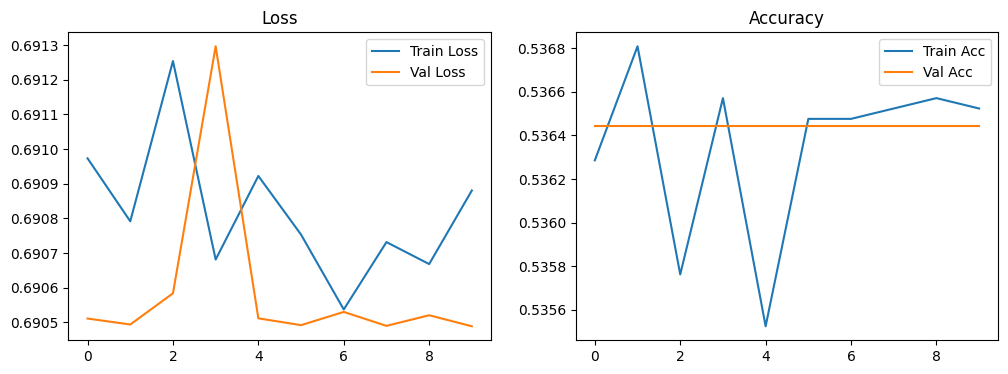

Saving model to: gru_model_weights\gru_model_1_model


INFO:tensorflow:Assets written to: gru_model_weights\gru_model_1_model\assets


INFO:tensorflow:Assets written to: gru_model_weights\gru_model_1_model\assets


Saving tokenizer to: gru_model_weights\gru_model_1_tokenizer
282/282 [==============================] - 55s 195ms/step - loss: 0.6905 - accuracy: 0.5364
Validation Loss: 0.6905, Validation Accuracy: 0.5364


In [7]:
if mode == ModelRunMode.TRAIN.value:
    # Load data
    df_merged = merge_data_by_id(input_csv, output_csv, sep=separator_char)

    # Text cleaning
    df_merged["Text"] = df_merged["Text"].apply(text_cleaning)

    # Convert Label: "AI" -> 1, "Human" -> 0
    y, texts = convert_labels_to_binary_and_get_text(df_merged)

    # Creating tokenizer
    tokenizer = preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<UNK>")
    tokenizer.fit_on_texts(texts)

    # Convert to sequences
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences
    X = preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')

    # Train/test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Create a GRU-Based classification model
    model = build_gru_model(vocab_size=vocab_size, max_len=max_len, embedding_dim=embedding_dim, gru_units=gru_units)

    # Display model sumary
    model.summary()

    # Training
    history = model.fit( X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Plot model learning curves
    plot_learning_curves(history)

    # Construct the file paths
    model_path = os.path.join(file_path, f"{model_prefix}_model")
    tokenizer_path = os.path.join(file_path, f"{model_prefix}_tokenizer")

    # Save the model weights
    print("Saving model to:", model_path)
    model.save(model_path)

    print("Saving tokenizer to:", tokenizer_path)
    with open(tokenizer_path, "wb") as f:
        pickle.dump(tokenizer, f)

    # Evaluate on validation set
    loss_val, acc_val = model.evaluate(X_val, y_val, verbose=verbose)
    print(f"Validation Loss: {loss_val:.4f}, Validation Accuracy: {acc_val:.4f}")

if mode == ModelRunMode.CLASSIFY.value:
    # Construct the file paths
    model_path = os.path.join(file_path, f"{model_prefix}_model")
    tokenizer_path = os.path.join(file_path, f"{model_prefix}_tokenizer")

    # Loading model
    model = tf.keras.models.load_model(model_path)

    print("Loading tokenizer:", tokenizer_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Reading input for classification
    df_new = pd.read_csv(input_csv, sep=separator_char)
    if "ID" not in df_new.columns or "Text" not in df_new.columns:
        raise ValueError("Input CSV must have 'ID' and 'Text' columns for classification.")

    # Clean text
    df_new["Text"] = df_new["Text"].apply(text_cleaning)
    texts = df_new["Text"].tolist()

    # Convert to sequences
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad
    X_new = preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')

    # Predict
    preds = model.predict(X_new)
    pred_bin = (preds >= 0.5).astype(int).flatten()
    pred_label = np.where(pred_bin == 1, "AI", "Human")

    # Save result
    df_out = pd.DataFrame({"ID": df_new["ID"], "Label": pred_label})
    df_out.to_csv(output_csv, sep=separator_char, index=False)
    print(f"Predictions saved to {output_csv}")
